Analysis Outline

Introduction of the dataset
- Acknowledgement of missing data.
- Definition of subsets of analysis (eg docs with at least 1 or at least 5 reviews)

Physician universe and demographics
- Coverage of healthgrades GI doctors (19,000+ national)
- Number of GI doctors in NY metro (947) = 6% of national active GI doctors (14,728 by ? year)
- Overall rating distribution

Influence of # of reviews
- Overall # of review distribution
- Number of reviews vs. rating (highlight top positive/negative)
- Doctors with large number of reviews: gender, age, location, rating

Influence of age
- Distribution of age
- Create age groups
- Number of reviews vs. age
- Rating by age group (are more experienced physicians better rated?)

Influence of gender
- Gender distribution: 22% female vs. 18% national
- Number of reviews is skewed by gender...
- ...but rating distribution is not

Influnece of educational history
- (todo) Educational history (where they came from)
- Rating distribution by top institutions
  (either #1 vs #2 or top few vs everyone else)

Influence of staff performance
- (todo) Rating vs. doctor score vs. staff score: heatmap
- Extreme: Doctors whose doc_score is very different from staff_score (check comments) 
 

In [122]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

pd.set_option('display.max_columns', 50)

In [95]:
r_fname = 'healthgrades_physicians_GI_NY_full_raw.csv'
fname = 'healthgrades_physicians_GI_NY_full.csv'
# Remove blank lines in raw csv file (scrapy bug for windows)
raw_data = pd.read_csv(r_fname)

# do not write index column
raw_data.to_csv(fname, index = False)  

# specify columns to read in for analysis
cols_in = ['name', 'hcp_id', 'age', 'gender', 'num_reviews', 'rating','doc_rating', 'staff_rating', \
            'practice_name', 'hosp_fellow', 'hosp_md', 'hosp_res', 
            'practice_addr','city', 'state', 'zipcode']

# read in fixed csv file
data = pd.read_csv(fname, usecols = cols_in)[cols_in] 
data.sample(5)

,name,hcp_id,age,gender,num_reviews,rating,doc_rating,staff_rating,practice_name,hosp_fellow,hosp_md,hosp_res,practice_addr,city,state,zipcode
884,"Dr. Cherif El Younis, MD",dr-cherif-el-younis-x7t3b,63.0,Male,2,5.0,5.0|4.5|5.0|5.0,4.5|3.0|2.5,OBH Division of Gastroenterology,SUNY Hlth Sci Ctr,"U Ein Shams, Cairo",SUNY Hlth Sci Ctr,"1 Brookdale Plz Ste 337, Brooklyn, NY, 11212",Brooklyn,NY,11212
643,"Dr. Eric Morgenstern, MD",dr-eric-morgenstern-yfwrn,55.0,Male,11,3.0,3.0|3.0|3.0|3.5,3.5|3.5|3.5,Jennifer L. Bonheur,Lenox Hill Hospital,New York Medical College,Lenox Hill Hospital,"1317 3rd Ave Fl 7, New York, NY, 10021",New York,NY,10021
920,"Dr. Henry Chiu, MD",dr-henry-chiu-3g6ks,43.0,Male,2,5.0,5.0|5.0|5.0|5.0,4.5|5.0|5.0,Advantage Care Physicians,St Lukes Roosevelt Hosp Ctr,University Of Maryland At Baltimore / Professi...,University Fl Shands Hosp,"447 Atlantic Ave, Brooklyn, NY, 11217",Brooklyn,NY,11217
890,"Dr. Morris Traube, MD",dr-morris-traube-yck49,65.0,Male,6,3.0,3.0|3.0|3.0|3.5,4.0|3.0|4.0,NYU LANGONE HOSPITAL CENTER,Yale University School Of Medicine,"New York State U, College Of Medicine-Downstate",Maimonides Medical Center,"240 E 38th St Fl 23, New York, NY, 10016",New York,NY,10016
269,"Dr. Isabelita Cordoba, MD",dr-isabelita-cordoba-39gcb,76.0,Female,1,5.0,5.0|5.0|5.0|5.0,5.0|5.0|5.0,NaN,V a New Jersey Health Care System-East Orange,Inst Med Far Eastern U,Va Hosp,"964 Avenue C, Bayonne, NJ, 07002",Bayonne,NJ,7002


In [96]:
# Data inspection
print(data.shape)
# check for duplicates based on hcp_id, there shouldn't be any
print(np.sum(data.duplicated(subset = ['hcp_id'])))
print(data.columns)
for field in data.columns:
    print(field, type(data.loc[0,field]))

(947, 16)
0
Index(['name', 'hcp_id', 'age', 'gender', 'num_reviews', 'rating',
       'doc_rating', 'staff_rating', 'practice_name', 'hosp_fellow', 'hosp_md',
       'hosp_res', 'practice_addr', 'city', 'state', 'zipcode'],
      dtype='object')
name <class 'str'>
hcp_id <class 'str'>
age <class 'numpy.float64'>
gender <class 'str'>
num_reviews <class 'numpy.int64'>
rating <class 'numpy.float64'>
doc_rating <class 'str'>
staff_rating <class 'str'>
practice_name <class 'str'>
hosp_fellow <class 'str'>
hosp_md <class 'str'>
hosp_res <class 'str'>
practice_addr <class 'str'>
city <class 'str'>
state <class 'str'>
zipcode <class 'numpy.int64'>


In [97]:
# change zipcode to 5 digit string    
if data['zipcode'].dtype == 'int64':
    data['zipcode'] = data['zipcode'].apply(lambda x: '{0:05d}'.format(x))

# fix some empty values in gender
data.loc[ data['gender'].isin(['Male','Female']) == False, ['gender'] ] = np.nan

# convert detailed doc_rating and staff_rating from string to float
def split_score(data_series):
    y = []
    for x in data_series:
        if pd.isna(x) == False:
            y.append(np.mean([float(xi) for xi in x.split('|')]))
        else:
            y.append(x)
    return y

data['doc_score'] = split_score(data['doc_rating'])

# print(data['doc_rating'].head(5))
# print(data['doc_score'].head(5))

data['staff_score'] = split_score(data['staff_rating'])

# print(data['staff_rating'].head(5))
# print(data['staff_score'].head(5))
# print(data['staff_rating'].tail(5))
# print(data['staff_score'].tail(5))

# drop the two string columns and other columns not used
data = data.drop(columns=['doc_rating', 'staff_rating'])

# re-order
cols_1 = ['name', 'hcp_id', 'age', 'gender', 'num_reviews', 'rating','doc_score', 'staff_score', \
            'practice_name', 'hosp_fellow', 'hosp_md', 'hosp_res', 
            'practice_addr','city', 'state', 'zipcode']
data=data[cols_1]

data.sample(5)

,name,hcp_id,age,gender,num_reviews,rating,doc_score,staff_score,practice_name,hosp_fellow,hosp_md,hosp_res,practice_addr,city,state,zipcode
259,"Dr. Michael Demyen, MD",dr-michael-demyen-3grnn,NaN,Male,0,NaN,NaN,NaN,University Physicians Assocs,NaN,Umdnj--Robert Wood Johnson Medical School,NaN,"90 Bergen St Ste 2100, Newark, NJ, 07103",Newark,NJ,07103
239,"Dr. Min Hsu, MD",dr-min-tsung-hsu-xvl44,72.0,Male,1,5.0,5.000,4.666667,Cwern Hsu Medical PC,NaN,NaN,NaN,"305 E 55th St, New York, NY, 10022",New York,NY,10022
924,"Dr. Robert Pfeffer, MD",dr-robert-pfeffer-3fkbq,57.0,Male,10,3.5,3.500,3.500000,CareMount Medical,Montefiore Mc,New York University School Of Medicine,Bellevue Hospital Center,"317 E 34th St Fl 5, New York, NY, 10016",New York,NY,10016
833,"Dr. Felice Schnoll-Sussman, MD",dr-felice-schnoll-sussman-xqd2p,49.0,NaN,18,3.0,3.125,4.000000,Weill Cornell Gastroenterology,NaN,Mount Sinai School of Medicine,Newyork-Presbyterian Hospital-Weill Cornell Me...,"1315 York Ave # Ground, New York, NY, 10021",New York,NY,10021
641,"Dr. Brian Turner, MD",dr-brian-turner-2hrg3,41.0,Male,7,4.5,4.500,4.333333,NaN,"Massachusetts General Hospital, Harvard Medica...",Harvard Medical School,Brigham and Women's Hospital,"1305 York Ave, New York, NY, 10021",New York,NY,10021


In [98]:
# count % of missing values by column
mv_cols = pd.DataFrame(data = np.sum(data.isnull(), axis = 0) / data.shape[0], columns = ['pct_mv'] )
print(mv_cols.to_string(formatters = {'pct_mv': '{:.0%}'.format}))

              pct_mv
name              0%
hcp_id            0%
age              22%
gender            7%
num_reviews       0%
rating           28%
doc_score        28%
staff_score      29%
practice_name    12%
hosp_fellow      41%
hosp_md          25%
hosp_res         33%
practice_addr     0%
city              0%
state             0%
zipcode           0%


In [99]:
# create indicator for whether the doctor has been reviewed or not
data['has_review'] = True
data.loc[ data['num_reviews'] == 0, 'has_review'] = False
print(data['has_review'].value_counts())

True     681
False    266
Name: has_review, dtype: int64


In [100]:
# summary stats of key numeric variables
# data.loc[:,['age','num_reviews','rating','doc_score','staff_score']].describe()
data['num_reviews'].describe()

count    947.000000
mean       7.357973
std       11.604459
min        0.000000
25%        0.000000
50%        4.000000
75%       11.000000
max      158.000000
Name: num_reviews, dtype: float64

Text(0.5,1,'Distribution of Overall Rating')

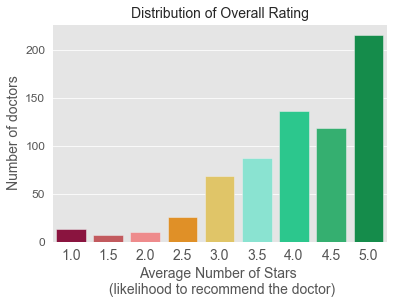

In [101]:
# use
# overall distribution of score among doctors with at least 1 review
colors = ["cranberry","faded red", "salmon pink", "tangerine", "maize", "tiffany blue", \
          "aqua green","algae green","emerald"]

ax = sns.countplot( x = 'rating', data = data, palette = sns.xkcd_palette(colors) )
plt.xticks(fontsize = 14)
plt.xlabel('Average Number of Stars \n (likelihood to recommend the doctor)', fontsize = 14)
plt.ylabel('Number of doctors', fontsize = 14)
plt.title('Distribution of Overall Rating', fontsize = 14)

It would appear that the majority of doctors are getting 4 stars and above, including more than 200 doctors getting perfect 5 stars. However, each of the rating the doctor receives is an average across all the patient reviews received by this provider. Obviously a 5 star rating based on just 1 review is not the same as a 5 star rating based on 20 reviews. Next we take a look at the number of reviews received by each doctor and how that influences the overall star rating.

Text(0.5,1,'Histogram of Number of Reviews \n for Gastroenterologists in New York Metro Area')

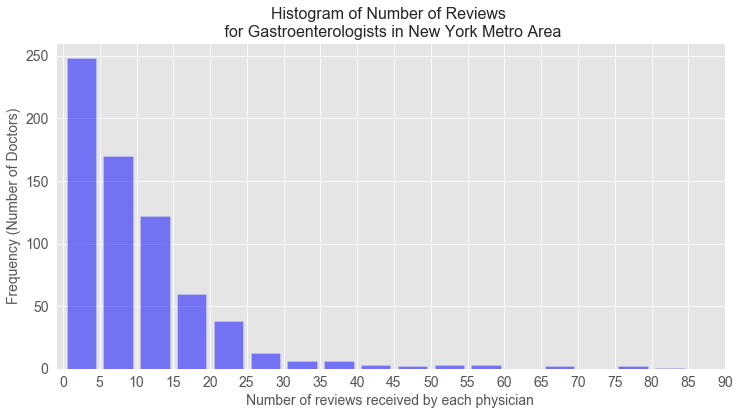

In [102]:
# use
# overall distribution of the number of reviews among doctors with at least one review (681, 72%)
# subdata: physicians with >= 1 reviews
subdata = data[ data['has_review'] == True ]
bstep = 5
bmax = int(round(subdata.num_reviews.max()/bstep)*bstep)
plt.figure(figsize=(12,6))
hout = plt.hist(subdata.num_reviews.dropna(), bins = range(0,bmax,bstep), color = "blue", alpha = 0.5, rwidth = 0.8)
plt.xticks(np.arange(-bstep*2,bmax+2*bstep,bstep), fontsize = 14)
plt.yticks(fontsize = 14)    
plt.xlim([-1,90])
plt.xlabel('Number of reviews received by each physician', fontsize = 14)
plt.ylabel('Frequency (Number of Doctors)',fontsize = 14)
plt.title('Histogram of Number of Reviews \n for Gastroenterologists in New York Metro Area', fontsize = 16)

In [103]:
#plt.figure()
#plt.plot(x = hout[1][1:], y = np.cumsum(hout[0])/np.sum(hout[0]) ) 
print(list(zip(hout[1][1:],np.cumsum(hout[0])/np.sum(hout[0]))))
# 20% doctors have >= 15 reviews 
# 39% doctors have >= 10 reviews
# 64% doctors have >= 5 reviews

[(5, 0.36470588235294116), (10, 0.6147058823529412), (15, 0.7941176470588235), (20, 0.8823529411764706), (25, 0.9382352941176471), (30, 0.9573529411764706), (35, 0.9661764705882353), (40, 0.975), (45, 0.9794117647058823), (50, 0.9823529411764705), (55, 0.986764705882353), (60, 0.9911764705882353), (65, 0.9911764705882353), (70, 0.9941176470588236), (75, 0.9941176470588236), (80, 0.9970588235294118), (85, 0.9985294117647059), (90, 0.9985294117647059), (95, 0.9985294117647059), (100, 0.9985294117647059), (105, 0.9985294117647059), (110, 0.9985294117647059), (115, 1.0), (120, 1.0), (125, 1.0), (130, 1.0), (135, 1.0), (140, 1.0), (145, 1.0), (150, 1.0), (155, 1.0)]


Although the healthgrades physician database appears to be quite comprehensive, the patient reviews are collected via a survey on the physician's page on healthgrades.com. Around 22% of physicians have not been reviewed. In the histogram above, we only consider physicians with at least 1 review (total 681 gastroenterologists). 

It's clear that the number of reviews per physician follows an exponential distribution, with 36% receiving less than 5 reviews, 25% receiving 5 to 9 reviews, and 39% receiving 10 reviews or more. Only 4.3% of doctors receive 30 reviews or more, and < 2% of doctors receive 50 reviews or more. Next we take a look at the relationship between the number of reviews and overall star rating. 

In [104]:
# Create categorical variable (L/M/H) based on num_reviews
# cut_bins = pd.IntervalIndex.from_tuples([(0, 5), (5, 10), (10, 200)])
# n_rev_c = pd.DataFrame(pd.cut(subdata['num_reviews'], bins = [0,5,10,200], right = False,  \
#                              labels = ['L', 'M', 'H'] ))

subdata['n_rev_c'] = pd.cut(subdata['num_reviews'], bins = [0,5,10,200], right = False,  \
                             labels = ['L', 'M', 'H'] )
# subdata.loc[:,['num_reviews','n_rev_c']].head(10)
# subdata['n_rev_c'].dtype

C:\Users\yanqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0, 50)

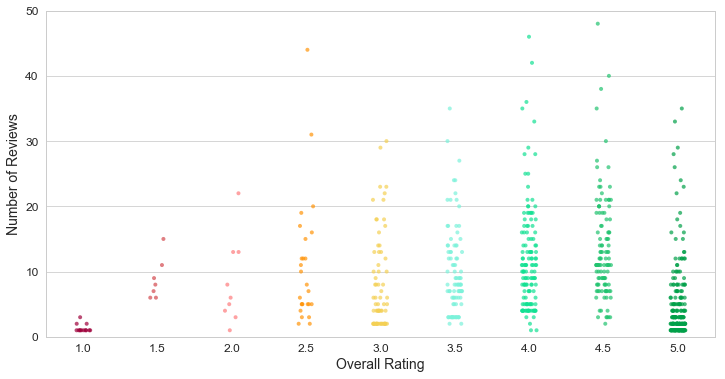

In [105]:
# use
# Number of reviews vs. overall rating
plt.figure(figsize = (12,6))
sns.set_style("whitegrid")
colors = ["cranberry","faded red", "salmon pink", "tangerine", "maize", "tiffany blue", \
          "aqua green","algae green","emerald"]
sns.stripplot(x="rating", y="num_reviews", data=subdata, size = 4, alpha = 0.7, jitter = True, \
              palette = sns.xkcd_palette(colors));
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')
plt.ylim(0,50)

Text(0,0.5,'Number of doctors')

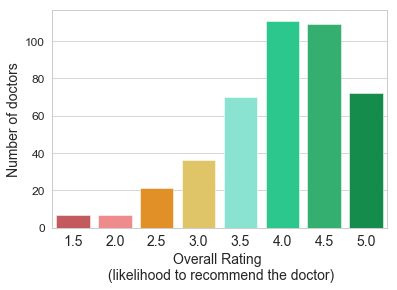

In [106]:
# use
# overall distribution of score among doctors with at least 5 reviews 
subdata5 = data.loc[ data['num_reviews'] >= 5 ]

colors = [ "faded red", "salmon pink", "tangerine", "maize", "tiffany blue", \
          "aqua green","algae green","emerald"]

ax = sns.countplot( x = 'rating', data = subdata5, palette = sns.xkcd_palette(colors) )
plt.xticks(fontsize = 14)
plt.xlabel('Overall Rating \n (likelihood to recommend the doctor)', fontsize = 14)
plt.ylabel('Number of doctors', fontsize = 14)

In [124]:
subdata5['rating'].value_counts() #/subdata5['rating'].count()

4.0    111
4.5    109
5.0     72
3.5     70
3.0     36
2.5     21
1.5      7
2.0      7
Name: rating, dtype: int64

In [125]:
# order is more correct than value_counts function
# stats.itemfreq(subdata5['rating'])
np.unique(subdata5['rating'], return_counts=True) 

(array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 array([  7,   7,  21,  36,  70, 111, 109,  72], dtype=int64))

In [108]:
subdata5['rating'].describe()

count    433.000000
mean       3.982679
std        0.792938
min        1.500000
25%        3.500000
50%        4.000000
75%        4.500000
max        5.000000
Name: rating, dtype: float64

The scatterplot of star rating vs. number of reviews shows doctors with the poorest ratings are less likely to get a large number reviews. Contrary to intuition, few patients who are willing to submit a review are motivated by a very negative experience with the doctor. Patients seem to be generally happy with the gastroenterologists in NY metro area. 

Indeed, when we focus on only the physicians with at least 5 reviews (subdata5, total 433 doctors), the distribution of the overall rating changes quite a bit. Notably the drop in the number of doctors getting 5 star ratings. This should be a more robust distribution with a minimally acceptable sample size on which each average star rating is based. The average rating is close to 4 and more than 70 doctors receive perfect 5 stars. 

These charts helps guide consumers in their interpretation of the ratings on healthgrades.com. One would perhaps be best to avoid the GI doctors with < 3 star rating based on 5 or more reviews. Similarly, to find top positively rated doctors, 5 star rating based on 5 or more reviews, 4.5 stars based on more than 10 reviews, or even more stringent criteria may be used. 

In [109]:
# who are the doctors with extremely large # of reviews
n_high = 50
subdata.loc[ subdata['num_reviews'] >= n_high, ['name','age','gender','num_reviews', \
                                            'rating','practice_name','practice_addr','hosp_fellow', 'hosp_md'] ]

,name,age,gender,num_reviews,rating,practice_name,practice_addr,hosp_fellow,hosp_md
562,"Dr. Azeem Khan, MD",59.0,Male,57,4.0,Forest Hills Gastroenterology,"10840 Queens Blvd, Forest Hills, NY, 11375",New York Medical College Westchester Medical C...,"Grant Medical College, Maharashtra University ..."
570,"Dr. Gary Gorodokin, MD",57.0,Male,112,4.5,Platinum Wellness Center,"2829 Ocean Pkwy, Brooklyn, NY, 11235",Gastroenterology - Long Island College Hospital,Medical School at SUNY Downstate Medical Cente...
571,"Dr. Nilesh Mehta, MD",44.0,Male,57,4.0,Digestive Disease Care,"10440 Queens Blvd Ste 1F, Forest Hills, NY, 11375",Upstate Med Ctr SUNY-Syracuse,Mgm Medical College
577,"Dr. Vijaypal Arya, MD",56.0,Male,69,4.5,Vijaypal Arya Gastroenterology PC,"7517 Metropolitan Ave Metrowell Health Center,...",Allegeny General Hospital (University Of Penns...,"Ravindra Nath Tagore Medical College, Rajastha..."
578,"Dr. Preeti Mehta, MD",44.0,Female,77,4.5,Digestive Disease Care,"6845 Main St, Flushing, NY, 11367",SUNY-Syracuse/Upstate Med Ctr,Mount Sinai School Of Medicine Of New York Uni...
582,"Dr. Daniel Alpert, MD",54.0,Male,158,4.5,"Daniel J Alpert, MD, PLLC","345 E 37th St Rm 304, New York, NY, 10016",New York University Med Center,Suny Downstate Medical Center College of Medicine
583,"Dr. Jeffrey Crespin, MD",52.0,Male,84,4.5,"Jeffrey S. Crespin, MD","210 E 47th St Apt 1A, New York, NY, 10017",Northwestern Memorial Hospital,Washington University St Louis
604,"Dr. Christine Frissora-Rodeo, MD",49.0,Female,52,4.0,Ira M Jacobson MD,"1305 York Ave, New York, NY, 10021",Colum-St Lukes RHC,Weill Cornell Medical College
605,"Dr. Ellen Scherl, MD",66.0,NaN,51,3.5,Jill Roberts Center for InflammatoryBowel Disease,"1315 York Ave # Mezzanine, New York, NY, 10021",Mount Sinai Medical Center,New York Medical College
617,"Dr. Lawrence Herman, MD",56.0,Male,66,4.5,Medical Associates Of Manhattan,"121 E 60th St Apt 9B, New York, NY, 10022",Memorial Sloan Kettering Cancer Center,Joan Sanford I Weill Medical College Of Cornel...


What other factors influence the doctor's star rating? One would reasonably expect more experienced doctors who has been practicing for longer will be reviewed more favorably. Using age as a proxy for years of experience, we look at how this factor relates to the star rating. 

737

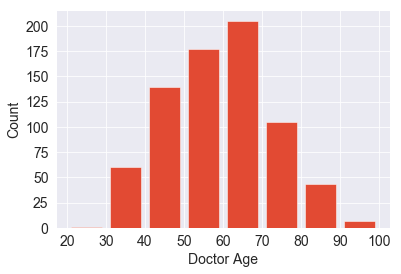

In [110]:
# use
# age distribution: 22% missing
sns.set_style('darkgrid')
plt.hist(data.age.dropna(), rwidth = 0.8, bins = range(20,110,10))
plt.xticks(range(20,110,10), fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Doctor Age')
plt.ylabel('Count')
# Majority of the gastroenterologists in NY metro area are between 50 and 70 years old
len(data.age.dropna())

In [111]:
# create age groups
edge_low = int(np.floor(min(data['age'])/10)*10)
edge_high = int(np.ceil(max(data['age'])/10)*10)
data['age_grp'] = pd.cut(data['age'], bins = np.arange(edge_low,edge_high+10,10), right = False)
data.loc[:,['age','age_grp']].sample(5)

,age,age_grp
423,48.0,"[40, 50)"
554,64.0,"[60, 70)"
716,65.0,"[60, 70)"
371,35.0,"[30, 40)"
800,54.0,"[50, 60)"


In [112]:
data['age_grp'].value_counts() #/data['age_grp'].value_counts().sum()

[60, 70)     205
[50, 60)     177
[40, 50)     139
[70, 80)     105
[30, 40)      60
[80, 90)      43
[90, 100)      7
[20, 30)       1
Name: age_grp, dtype: int64

Text(0,0.5,'Number of Reviews')

<Figure size 720x432 with 0 Axes>

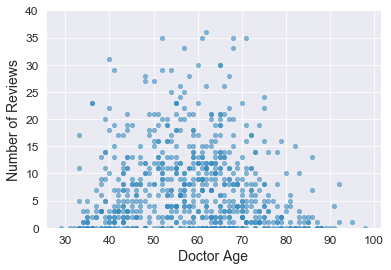

In [113]:
# use
plt.figure(figsize =(10,6))
data.plot(kind='scatter',x='age', y='num_reviews', alpha = 0.6)
plt.ylim(0,40)
plt.xlabel('Doctor Age', fontsize = 14)
plt.ylabel('Number of Reviews', fontsize = 14)
# doctors between 50 and 70 years old tend to get a larger number of reviews on average, and the younger and older age 
# groups generally receive fewer reviews. This could be due to the 50-70 year old physicians having a longer practicing 
# history and cumulative patient count than the younger group, and also being more actively practicing than the older group.
# This could also be due to a selection bias from patients for GI doctors in the 50-70 age group.

In [118]:
subdata5 = data.loc[ data['num_reviews'] >= 5 ]
subdata5.head(2)

,name,hcp_id,age,gender,num_reviews,rating,doc_score,staff_score,practice_name,hosp_fellow,hosp_md,hosp_res,practice_addr,city,state,zipcode,has_review,age_grp
0,"Dr. Blair Lewis, MD",dr-blair-lewis-2gfpg,62.0,Male,26,5.0,4.875,4.666667,Blair S Lewis MD PC,Mt Sinai Med Center,Albert Einstein College Of Medicine Of Yeshiva...,Montefiore Med Center,"1067 5th Ave, New York, NY, 10128",New York,NY,10128,True,"[60, 70)"
14,"Dr. Zamir Brelvi, MD",dr-zamir-brelvi-xy8pj,59.0,Male,15,4.0,4.125,3.833333,NaN,NaN,Umdnj--New Jersey Medical School,Umdnj-University Hospital,"90 Bergen St, Newark, NJ, 07103",Newark,NJ,07103,True,"[50, 60)"


Text(0,0.5,'Overall Rating')

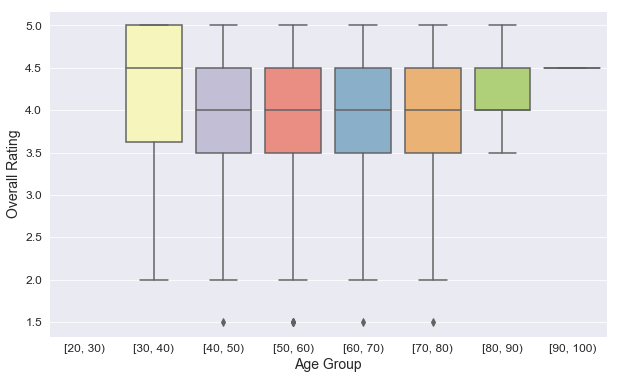

In [120]:
# use
plt.figure(figsize =(10,6))

# 
subdata5 = data.loc[ data['num_reviews'] >= 5 ]
sns.boxplot(x="age_grp", y="rating", data=subdata5, palette="Set3")
plt.xlabel('Age Group')
plt.ylabel('Overall Rating')

In [137]:
subdata5['age_grp'].value_counts()

[50, 60)     125
[60, 70)     123
[40, 50)      72
[70, 80)      45
[30, 40)      18
[80, 90)       7
[90, 100)      1
[20, 30)       0
Name: age_grp, dtype: int64

In [164]:
# test if the age group [30, 40) has different average rating from the other groups
age_grps = np.sort(subdata5['age_grp'].unique().dropna())

age_grp_rating = {}
for grp in age_grps:
    age_grp_rating[str(grp)] = subdata5.loc[ subdata5['age_grp'] == grp, ['rating'] ]  

stats.f_oneway(age_grp_rating['[30, 40)'], age_grp_rating['[40, 50)'] ,age_grp_rating['[50, 60)'], \
              age_grp_rating['[60, 70)'])

F_onewayResult(statistic=array([0.53644269]), pvalue=array([0.65760831]))

In [121]:
subdata5.shape[0]

433

How does the gender of the doctor impact the rating? Is there any difference between female and male doctors?

In [229]:
# use
# gender distribution (884 doctors with gender info, 7% missing)
# total 688 male and 196 female doctors: 78% of NY metro GI docs in the HG database are male 
# to look up: % F / M GI docs in the US = 17.6% (out of 14,728 total)
print(data.gender.value_counts())

# counts of each variable split by gender
# 75% of male doctors have been reviewed, while only 57% of female doctors have been reviewed
data.groupby('gender').count()
plt.figure(figsize =(3,3))

Male      688
Female    196
Name: gender, dtype: int64


<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

4.642857142857143
8.200581395348838


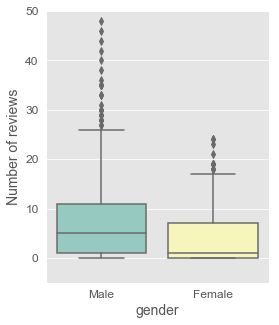

In [200]:
# use
# distribution of reviews by gender
# sns.boxplot(x='gender', y='num_reviews', data=subdata.loc[ subdata['num_reviews'] <= 50 ])
plt.figure(figsize = (4,5))
sns.boxplot( x ='gender', y ='num_reviews', data=data, palette = 'Set3')
plt.ylim(-5, 50)
plt.ylabel('Number of reviews')
stats.ttest_ind(data.loc[ data['gender'] == 'Female', 'num_reviews'], \
                data.loc[ data['gender'] == 'Male', 'num_reviews'])
# Female GI doctors receive seem to have lower visibility among patients and receive fewer reviews
# The doctors who receive extremely large number of reviews are almost all male doctors
print(data.loc[ data['gender'] == 'Female', 'num_reviews'].mean())
print(data.loc[ data['gender'] == 'Male', 'num_reviews'].mean())

Ttest_indResult(statistic=-0.9629752660845635, pvalue=0.3361388240995673)

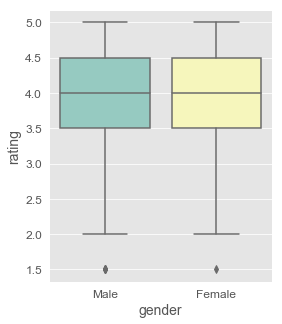

In [193]:
# use
# distribution of overall rating by gender
plt.figure(figsize = (4,5))
sns.boxplot( x ='gender', y ='rating', data=subdata5, palette = 'Set3')
np.sum(subdata5.loc[:,['gender','rating']].isnull().any(axis = 1))
# no difference in rating distribution for female & male doctors with 5 or more reviews


In [ ]:
# plt.figure(figsize = (12,4))
# plt.subplot(121)
# sns.boxplot( y ='gender', x ='num_reviews', data=data, palette = 'Set3')
# plt.xlim(-5, 50)
# plt.xlabel('Number of reviews')
# plt.subplot(122)
# sns.boxplot( y ='gender', x ='rating', data=subdata5, palette = 'Set3')
# plt.xlabel('Rating')

In [ ]:
numdata = subdata.loc[:,['age', 'num_reviews', 'doc_score', 'staff_score', 'rating']]
numdata.corr(min_periods = 50)

In [228]:
# use
scores = subdata5.loc[:,['doc_score','staff_score', 'rating']]
scores.corr(min_periods = 50)

,doc_score,staff_score,rating
doc_score,1.000000,0.841663,0.957498
staff_score,0.841663,1.000000,0.860684
rating,0.957498,0.860684,1.000000


In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(scores.loc[:,['rating','staff_score','doc_score']], \
               alpha=0.2, figsize=(12, 12), diagonal='hist')

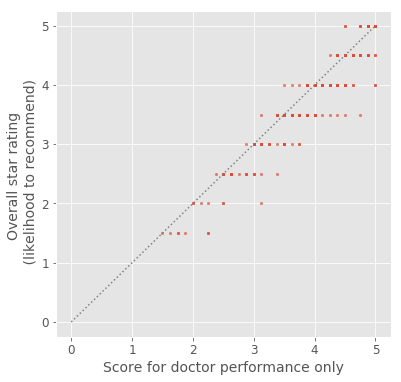

In [44]:
plt.figure(figsize = (6,6))
plt.scatter(x="doc_score", y="rating", data=subdata5, alpha = 0.7, s = 6);
plt.xlabel('Score for doctor performance only')
plt.ylabel('Overall star rating \n (likelihood to recommend)')
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5), color = 'gray', linestyle=':')
plt.show()

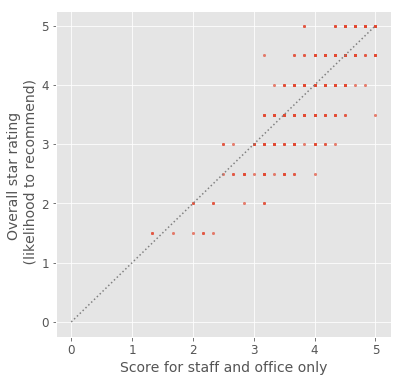

In [45]:
plt.figure(figsize = (6,6))
plt.scatter(x="staff_score", y="rating", data=subdata5, alpha = 0.7, s = 6);
plt.xlabel('Score for staff and office only')
plt.ylabel('Overall star rating \n (likelihood to recommend)')
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5), color = 'gray', linestyle=':')
plt.show()

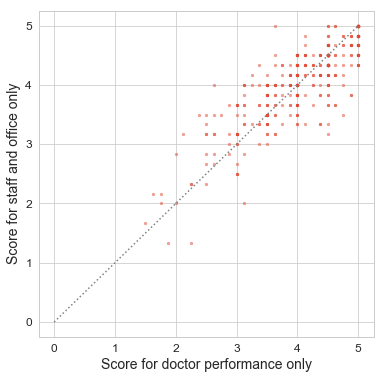

In [217]:
plt.figure(figsize = (6,6))
plt.scatter(x="doc_score", y="staff_score", data=subdata5, s = 7, alpha = 0.5);
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5), color = 'gray', linestyle=':')
plt.xlabel('Score for doctor performance only')
plt.ylabel('Score for staff and office only')
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.show()

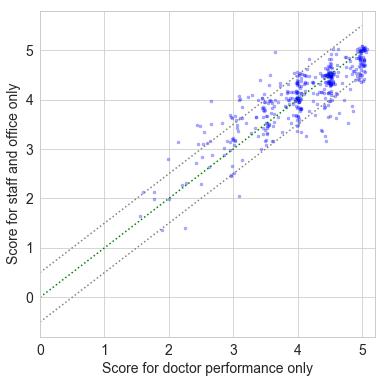

In [218]:
# use
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)

sns.set_style('whitegrid')
plt.figure(figsize = (6,6))
jitter( subdata5['doc_score'], subdata5['staff_score'], s = 9, alpha = 0.3);
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5), color = 'green', linestyle=':')
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5) + 0.5, color = 'gray', linestyle=':')
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5) - 0.5, color = 'gray', linestyle=':')
plt.xlabel('Score for doctor performance only')
plt.ylabel('Score for staff and office only')
plt.xlim(0,5.2)
plt.show()

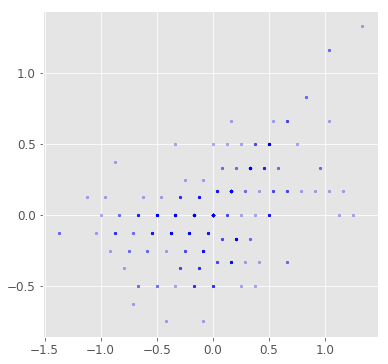

In [43]:
plt.figure(figsize = (6,6))
xval = subdata5['doc_score'] - subdata5['staff_score']
yval = subdata5['rating'] - subdata5.loc[:,['doc_score','staff_score']].min(axis = 1)
plt.scatter(xval, yval, s= 7, alpha = 0.3, color = 'b')

(-1.5, 1.5)

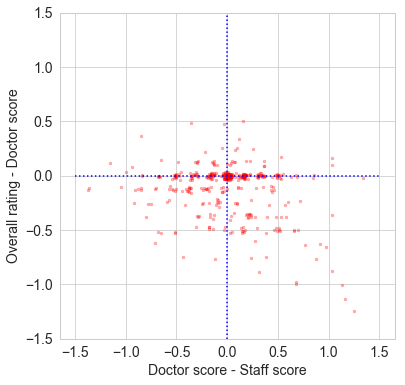

In [227]:
# use
sns.set_style('whitegrid')
plt.figure(figsize = (6,6))
xval = subdata5['doc_score'] - subdata5['staff_score']
yval = subdata5['rating'] - subdata5['doc_score']
jitter(xval, yval, s = 8, alpha = 0.3, c = 'r')
plt.plot(np.arange(-1.5,2,0.5), np.zeros(len(np.arange(-1.5,2,0.5))), color = 'b', linestyle=':')
plt.plot(np.zeros(len(np.arange(-1.5,2,0.5))), np.arange(-1.5,2,0.5), color = 'b', linestyle=':')
plt.xlabel('Doctor score - Staff score')
plt.ylabel('Overall rating - Doctor score')
plt.ylim(-1.5,1.5)
# plt.savefig('score difference scatter', format = 'png')

In [98]:
# subdata5.to_csv('temp.csv',index = False)